In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [158]:
from pathlib import Path
from openslide import OpenSlide, open_slide
from openslide.deepzoom import DeepZoomGenerator
import numpy as np
import pandas as pd
from tqdm import tqdm
import redis
from io import BytesIO
from timeit import default_timer as timer

In [52]:
class PILBytesIO(BytesIO):
    def fileno(self):
        '''Classic PIL doesn't understand io.UnsupportedOperation.'''
        # TODO: Check this exception out!!!
        raise AttributeError('Not supported')

In [46]:
def convertBytes(B, result="MB"):
    B = float(B)
    KB = float(1024) 
    MB = float(KB ** 2) # 1,048,576
    GB = float(KB ** 3) # 1,073,741,824
    TB = float(KB ** 4) # 1,099,511,627,776
    
    if result=="KB":
        return B / KB
    elif result=="MB":
        return B / MB
    elif result=="GB":
        return B / GB
    elif result=="TB":
        return B / TB
    
    return B 

In [171]:
r = redis.Redis(host='localhost', port=6379, db=1)
r.ping()

True

In [175]:
r.config_get('maxmemory')

{'maxmemory': '3221225472'}

In [15]:
slide_path = Path("D:\Datasets\ScannerStudy\Aperio\CCMCT\A_CCMCT_518711B_1.svs")
slide_path.exists()

True

In [16]:
osr = open_slide(str(slide_path))
osr

OpenSlide('D:\\Datasets\\ScannerStudy\\Aperio\\CCMCT\\A_CCMCT_518711B_1.svs')

In [17]:
slide = DeepZoomGenerator(osr)
slide

DeepZoomGenerator(OpenSlide('D:\\Datasets\\ScannerStudy\\Aperio\\CCMCT\\A_CCMCT_518711B_1.svs'), tile_size=254, overlap=1, limit_bounds=False)

In [18]:
slide.level_count

18

In [19]:
slide.tile_count

187662

In [21]:
slide.level_dimensions

((1, 1),
 (2, 2),
 (4, 3),
 (7, 6),
 (14, 11),
 (27, 21),
 (53, 41),
 (106, 82),
 (211, 164),
 (422, 328),
 (844, 655),
 (1688, 1310),
 (3375, 2619),
 (6750, 5238),
 (13500, 10475),
 (27000, 20949),
 (54000, 41897),
 (107999, 83794))

In [20]:
slide.level_tiles

((1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (2, 2),
 (4, 3),
 (7, 6),
 (14, 11),
 (27, 21),
 (54, 42),
 (107, 83),
 (213, 165),
 (426, 330))

In [180]:
%%time

tile = slide.get_tile(0, (0, 0))
print(np.array(tile).mean())
tile

184.0
Wall time: 1.35 s


In [176]:
import sys

In [179]:
convertBytes(sys.getsizeof(image_buf))

0.03277873992919922

In [159]:
%%time

mB = 0
keys = {}
num_tiles = 0
for level, tiles in enumerate(slide.level_tiles):
    
    level += 1
    num_x_tiles, num_y_tiles = tiles
    
    start = timer()
    for x in range(num_x_tiles):
        for y in range(num_y_tiles):
            
            tile = slide.get_tile(level, (x, y))
            
            buf = PILBytesIO()
            tile.save(buf, "jpeg", quality=90)
            image_buf = buf.getvalue()

            key = f"tile/{level}/{x}/{y}/"
            r.set(key, image_buf, 60*60)
            
            keys[key] = convertBytes(r.execute_command("MEMORY USAGE", key))
        
    num_tiles += num_x_tiles*num_y_tiles
    print(f"Level: {level}  Size: {sum(keys.values()):3.2f}MB Tiles: {tiles} Total: {num_tiles}  Sec. {timer() - start:.1f}")
    if level == 16:
        break

Level: 1  Size: 0.00MB Tiles: (1, 1) Total: 1  Sec. 1.2
Level: 2  Size: 0.00MB Tiles: (1, 1) Total: 2  Sec. 1.2
Level: 3  Size: 0.00MB Tiles: (1, 1) Total: 3  Sec. 1.2
Level: 4  Size: 0.00MB Tiles: (1, 1) Total: 4  Sec. 1.1
Level: 5  Size: 0.00MB Tiles: (1, 1) Total: 5  Sec. 1.1
Level: 6  Size: 0.01MB Tiles: (1, 1) Total: 6  Sec. 1.1
Level: 7  Size: 0.01MB Tiles: (1, 1) Total: 7  Sec. 1.2
Level: 8  Size: 0.02MB Tiles: (1, 1) Total: 8  Sec. 1.1
Level: 9  Size: 0.04MB Tiles: (1, 1) Total: 9  Sec. 0.1
Level: 10  Size: 0.12MB Tiles: (2, 2) Total: 13  Sec. 0.4
Level: 11  Size: 0.38MB Tiles: (4, 3) Total: 25  Sec. 0.4
Level: 12  Size: 1.36MB Tiles: (7, 6) Total: 67  Sec. 2.6
Level: 13  Size: 5.34MB Tiles: (14, 11) Total: 221  Sec. 37.6
Level: 14  Size: 19.20MB Tiles: (27, 21) Total: 788  Sec. 36.5
Level: 15  Size: 74.16MB Tiles: (54, 42) Total: 3056  Sec. 374.7
Level: 16  Size: 261.35MB Tiles: (107, 83) Total: 11937  Sec. 499.5
Wall time: 16min 1s


In [170]:
%%timeit

level, x, y = 17, 0, 0

slide.get_tile(level, (x, y))

1.9 ms ± 34.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Wall time: 2 ms


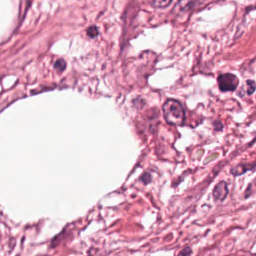

In [169]:
%%time
slide.get_tile(17, (x, y))

In [161]:
%%timeit

r.get(f"tile/{level}/{x}/{y}/")

1.12 ms ± 54.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [156]:
r.debug_object(f"tile/{level}/{x}/{y}/")

{'type': 'Value',
 'at': '0x7f72e318c8c0',
 'refcount': 1,
 'encoding': 'raw',
 'serializedlength': 45676,
 'lru': 5807039,
 'lru_seconds_idle': 1129}

In [113]:
%%time

byte_array = []
for key, value in tqdm(keys.items()):
    
    r.get(key)
    
    _, level, x, y, _ = key.split("/")
    byte_array.append([key, int(level), int(x), int(y), float(value)])

100%|█████████████████████████████████████████████████████████████████████████████| 3056/3056 [00:03<00:00, 933.10it/s]

Wall time: 3.28 s


In [114]:
df = pd.DataFrame(byte_array, columns=["key", "level", "x", "y", "size"])
df

,key,level,x,y,size
0,tile/1/0/0/,1,0,0,0.000786
1,tile/2/0/0/,2,0,0,0.000786
2,tile/3/0/0/,3,0,0,0.000786
3,tile/4/0/0/,4,0,0,0.000786
4,tile/5/0/0/,5,0,0,0.001030
...,...,...,...,...,...
3051,tile/15/53/37/,15,53,37,0.039116
3052,tile/15/53/38/,15,53,38,0.046928
3053,tile/15/53/39/,15,53,39,0.039116
3054,tile/15/53/40/,15,53,40,0.039116


In [121]:
%%timeit

r.get("/images/image/482/1/1/tile_files/13/16_9.jpeg")

792 µs ± 25.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
